In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import time
import requests

%matplotlib inline

In [2]:
from pylab import rcParams
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from time import sleep
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 15
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

### 1.  Download datasets
Three dataset files of listening records on website[last.fm] are downloaded from [https://grouplens.org/datasets/hetrec-2011/]  
   (1)[tags.dat]: This file contains the set of tags.  
   (2)[artists.dat]: This file contains information about music artists listened and tagged by the users.   
   (3)[user_taggedartists.dat]: These files contain the tag assignments of artists provided by each particular user.  

### 2: Analyse [tags.dat] file, use natural language processing to sort word frequencies in all tags.

11946
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal
<type 'numpy.int64'>


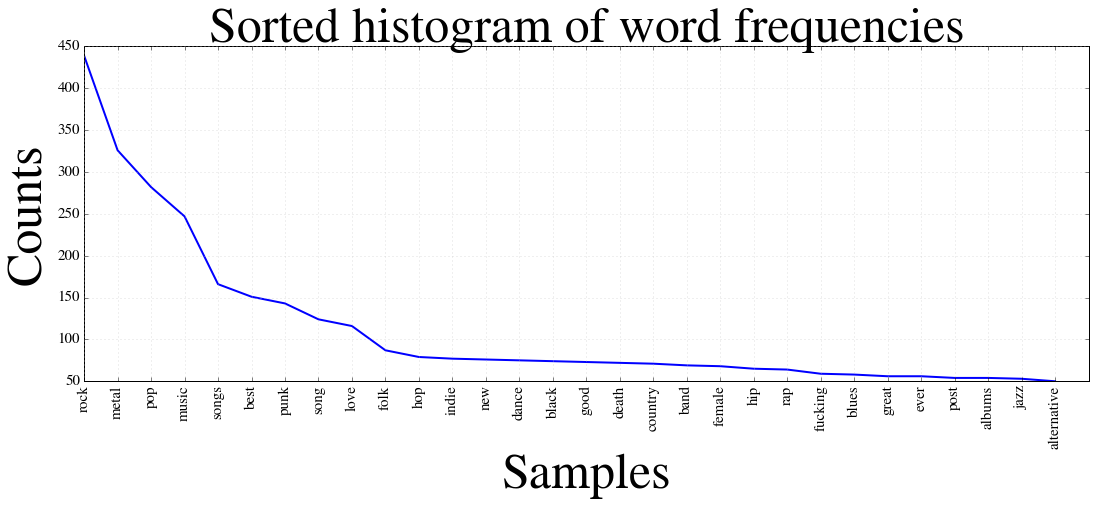

In [4]:
df_tags = pd.read_csv('./music/MusicInfo/tags.dat', sep='\t') 
print len(df_tags)
print df_tags.head()
print type(df_tags.tagID[0])
all_tags = df_tags.tagValue.str.rstrip().to_string(header=False, index=False).replace('\n',',')

tokenizer = RegexpTokenizer('\w+')
tokenized_tags = tokenizer.tokenize(all_tags)
stopwords = nltk.corpus.stopwords.words('english')
cleared_tokenized_tags = [word for word in tokenized_tags if word.lower() not in stopwords]
cleared_text_tags = nltk.Text(cleared_tokenized_tags)

f = plt.figure( figsize=(18, 6))
plt.xlabel('Words', size=50)
plt.ylabel('Counts', size=50)
plt.title('Sorted histogram of word frequencies', size=50)
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
cleared_text_tags.plot(30)
ax = f.get_axes()

### 3: According to above figure,  determine the music styles that are used in this project. 
(Duo to our private computers' capacity, just around 1,300 musics, 150 musics per music styles, total 8 music styles, are downloaded in this project.)

(1) Eight most popular music styles [0:'rock',1:'metal',2:'pop',3:'punk',4:'folk',5:'hop',6:'black',7:'country'] are selected.  
(2) Select the tags which just contains key words ['rock','metal','pop','punk','folk','hop','black','country'] in [tags.dat]. 

In [5]:
want_music_styles = ['rock','metal','pop','punk','folk','hop','black','country']
want_tags = pd.DataFrame()
want_tags['styleID'] = ''
want_tags['style'] = ''
for i in range(0, len(want_music_styles)):
    want_tags = want_tags.append(df_tags[df_tags['tagValue'].str.contains(want_music_styles[i])],ignore_index=True)
want_tags.tagID=want_tags.tagID.astype(int)

for j in range(0, len(want_tags)):
    for k in range(0, len(want_music_styles)):
        if want_tags.iloc[j]['tagValue'].find(want_music_styles[k]) > -1:
            want_tags.loc[j, 'styleID'] = k
            want_tags.loc[j, 'style'] = want_music_styles[k]
        
print len(want_tags)
want_tags.head()

1768


D:\PostGraduateStudy\DataScience\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,style,styleID,tagID,tagValue
0,rock,0,3,goth rock
1,rock,0,72,hard rock
2,rock,0,73,rock
3,rock,0,75,psychedelic rock
4,rock,0,77,ambient rock


### 4: Select the artists who are tagged as  ['rock','metal','pop','punk','folk','hop','black','country']

(1) Read file [user_taggedartists.dat]  
(2) Combine with the dataframe [want_tags] that is created in step 2 on key [tagID]    
(3) Drop all other rows that are not in the 8 music styles

In [12]:
#read user_taggedartists.dat
df_user_tagged_artists = pd.read_csv('./music/MusicInfo/user_taggedartists.dat', sep='\t') 
print df_user_tagged_artists.head()

#join the dataframe[df_user_tagged_artists] and [want_tags] on key [tagID]
df_artists_with_want_style = df_user_tagged_artists.join(want_tags.set_index('tagID'), how='left', on='tagID')
#drop rows which are not the 8 most popular music styles.
df_artists_with_want_style.dropna(inplace=True)
df_artists_with_want_style.drop(columns=['day','month','year','userID','tagID','tagValue'],inplace=True)
df_artists_with_want_style.styleID = df_artists_with_want_style.styleID.astype(int)
df_artists_with_want_style.drop_duplicates(subset=['artistID'], inplace=True)
print df_artists_with_want_style.head()
print len(df_artists_with_want_style)

   userID  artistID  tagID  day  month  year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
2       2        52     18    1      4  2009
3       2        52     21    1      4  2009
4       2        52     41    1      4  2009
    artistID style  styleID
3         52   hop        5
14        73   hop        5
20        94   hop        5
26        96   pop        2
28       995   pop        2
8085


In [13]:
#0:'rock',1:'metal',2:'pop',3:'punk',4:'folk',5:'hop',6:'black',7:'country'
print 'Number of rock style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 0]))
print 'Number of metal style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 1]))
print 'Number of pop style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 2]))
print 'Number of punk style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 3]))
print 'Number of folk style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 4]))
print 'Number of hop style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 5]))
print 'Number of black style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 6]))
print 'Number of country style music: ' + str(len(df_artists_with_want_style['artistID'][df_artists_with_want_style['styleID'] == 7]))

Number of rock style music: 2804
Number of metal style music: 1096
Number of pop style music: 2077
Number of punk style music: 536
Number of folk style music: 434
Number of hop style music: 821
Number of black style music: 133
Number of country style music: 184


### 5: Get the URLs of last.fm for the artists who are tagged as the eight selected music styles 

(1) Read file [artists.dat]  
(2) Combine with the dataframe [df_artists_with_want_style] that is created in step 4 on key [artistID]    

In [14]:
#read artists.dat, according ID get the URL
df_artists = pd.read_csv('./music/MusicInfo/artists.dat', sep='\t') 
print len(df_artists)
df_artists.head(5)

17632


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [15]:
#join the dataframe[df_artists_with_want_style] and [df_artists] on key [id]
df_artists_with_want_style_url = df_artists_with_want_style.join(df_artists.set_index('id'), how='left', on='artistID')
df_artists_with_want_style_url.dropna(inplace=True)
df_artists_with_want_style_url.drop(columns=['pictureURL'],inplace=True)
df_artists_with_want_style_url.reset_index(drop=True, inplace= True)
print len(df_artists_with_want_style_url)
df_artists_with_want_style_url.head()

7889


,artistID,style,styleID,name,url
0,52,hop,5,Morcheeba,http://www.last.fm/music/Morcheeba
1,73,hop,5,Café Del Mar,http://www.last.fm/music/Caf%C3%A9+Del+Mar
2,94,hop,5,Ministry of Sound,http://www.last.fm/music/Ministry+of+Sound
3,96,pop,2,Fleetwood Mac,http://www.last.fm/music/Fleetwood+Mac
4,995,pop,2,China Crisis,http://www.last.fm/music/China+Crisis


### 6: Get the youtube URLs from webpage of last.fm by using web scrapping 
##### Because most of the music of this dataset on last.fm are linked to youtube, in order to downloading musics, youtube URL need to be found on the webpages of last.fm for each music
(1) Function [get_youtube_url] is used to get youtube URL according to URL of last.fm.  
(2) For each music style, try to get no more than 200 musics from youtube.    
(3) Save the music information with youtube URL, music style name, music style id into file[Step1_artists_with_youtube_url.csv].

In [16]:
#according to the url of [www.last.fm], get the youtube url
def get_youtube_url(last_fm_url):
    youtube_url = ''
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0'}
    response = requests.get(last_fm_url, headers=headers)
    scraping = BeautifulSoup(response.content, 'lxml')
    youtube_links = scraping.find_all(name='a',attrs={'class':' image-overlay-playlink-link js-playlink desktop-playlink ', })
    if len(youtube_links) > 0:
        youtube_url = youtube_links[0].attrs['data-youtube-url']
    
    return youtube_url
    

In [116]:
#try to get Youtube play URLs for 200 songs for each styles, respectively.
df_artists_with_youtube_url = pd.DataFrame()
#0:'rock',1:'metal',2:'pop',3:'punk',4:'folk',5:'hop',6:'black',7:'country'
SONGS_COUNT=200
count=0
count_rock=0
count_metal=0
count_pop=0
count_punk=0
count_folk=0
count_hop=0
count_black=0
count_country=0

for i in range(0, len(df_artist_with_want_style_url)):
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 0) & (count_rock < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_rock = count_rock + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 1) & (count_metal < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_metal = count_metal + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 2) & (count_pop < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_pop = count_pop + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 3) & (count_punk < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_punk = count_punk + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 4) & (count_folk < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_folk = count_folk + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 5) & (count_hop < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_hop = count_hop + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 6) & (count_black < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_black = count_black + 1
            count = count + 1
            
    if (df_artists_with_want_style_url.iloc[i]['styleID'] == 7) & (count_country < SONGS_COUNT):
        youtube_url = get_youtube_url(df_artists_with_want_style_url.iloc[i]['url'])
        if youtube_url != '':
            df_artists_with_youtube_url.loc[count, 'artistID'] = df_artists_with_want_style_url.iloc[i]['artistID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'style'] = df_artists_with_want_style_url.iloc[i]['style']
            df_artists_with_youtube_url.loc[count, 'styleID'] = df_artists_with_want_style_url.iloc[i]['styleID'].astype(str)
            df_artists_with_youtube_url.loc[count, 'name'] = df_artists_with_want_style_url.iloc[i]['name']
            df_artists_with_youtube_url.loc[count, 'youtube_url'] = youtube_url
            count_country = count_country + 1
            count = count + 1

In [119]:
df_artist_with_youtube_url.to_csv('./music/MusicInfo/Step1_artists_with_youtube_url.csv', index=False)